In [224]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
import pandas as pd
import itertools
import seaborn as sns


Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks
You will investigate the five hallmarks of stochastic SIR dynamics using an event drive
SIR model:
1. variability;
2. negative co-variances;
3. increased transients;
4. stochastic resonance;
5. extinctions.


In [203]:
def sir(variables, t, beta, gamma):
    S = variables[0]
    I = variables[1]
    R = variables[2]

    N = S + I + R

    dSdt = -beta * I * S / N
    dIdt = beta * I * S / N - gamma * I
    dRdt = gamma * I

    return([dSdt, dIdt, dRdt])

Implement Gillespies algorithm
Write some python code to implement Gillespies Algorithm (GA)
1. You should define the
events and the rates of each event for the SIR model. Keep in mind it may be insightful
to compare the GA stochastic simulation with an equivalent deterministic ODE model.

In [204]:
def Gillespies(S_init, I_init, R_init, tend, beta, gamma, noise_controller=1):
    # Initialize lists with initial conditions
    S = [S_init]
    I = [I_init]
    R = [R_init]
    t = [0]

    run_count = 0
    while t[-1] < tend and (S[-1] + I[-1] + R[-1] >= 1):
        # Get Population
        N = S[-1] + I[-1] + R[-1]

        # Get the probabilities: [S -> I, I -> R]
        props = [beta * I[-1] * S[-1] / N, gamma * I[-1]]

        # Get sum of probability
        prop_sum = sum(props)

        try:
            # Determine the time until the next event occurs based on the probability sum.
            tau = np.random.exponential(scale=1 / prop_sum)

            # Append new time point only once
            t_new = t[-1] + tau

            # Generate random number    
            rand = random.uniform(0, 1)

            # See if Susceptible becomes Infected
            if rand * prop_sum <= (props[0] * noise_controller):
                S_new = S[-1] - 1
                I_new = I[-1] + 1
                R_new = R[-1]

            # Else, Infected becomes Recovered
            else:
                S_new = S[-1]
                I_new = I[-1] - 1
                R_new = R[-1] + 1

            # Append the new values to the lists
            S.append(S_new)
            I.append(I_new)
            R.append(R_new)
            t.append(t_new)

        except ZeroDivisionError:
            print(f"ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count {run_count}")
            run_count += 1
            if run_count > 10:
                print("Stochastic extinction is happening too often, choose different parameters")
                break

    return S, I, R, t

In [205]:
# Initial conditions
S_init = 200
I_init = 1
R_init = 0
t = 0

# Parameters
beta = 0.04
gamma = 0.01
tend = 500

In [206]:
# Initialization and simulation
n_runs = 3
results = []

max_length = 0  # Initialize max_length outside the loop

for i in range(n_runs):
    S, I, R, t = Gillespies(S_init, I_init, R_init, tend, beta, gamma)

    # Update max_length if needed
    max_length = max(max_length, len(t))

    # Append results without interpolation for now
    results.append((np.array(S), np.array(I), np.array(R), np.array(t)))

# Interpolate results to have consistent time points
interp_t = np.linspace(0, tend, max_length)
interp_S = np.array([np.interp(interp_t, result[3], result[0]) for result in results])
interp_I = np.array([np.interp(interp_t, result[3], result[1]) for result in results])
interp_R = np.array([np.interp(interp_t, result[3], result[2]) for result in results])

# Calculate mean after interpolation
mean_S = np.mean(interp_S, axis=0)
mean_I = np.mean(interp_I, axis=0)
mean_R = np.mean(interp_R, axis=0)

In [207]:
def RMSE(x, y):
    if not len(x) == len(y):
        raise ValueError("x and y must be of same length")
    return np.sqrt(np.mean(np.square(x - y)))

In [208]:
y0 = [200, 1, 0]
y = odeint(sir, y0, t, args=(beta, gamma))

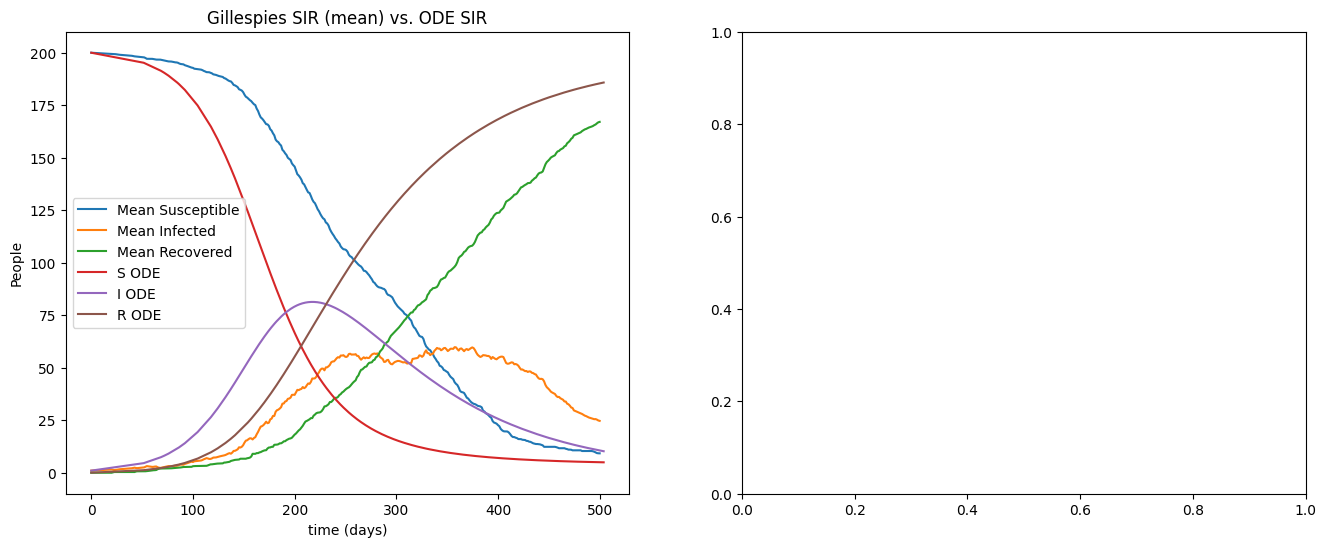

In [209]:
# plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(interp_t, mean_S, label='Mean Susceptible')
ax1.plot(interp_t, mean_I, label='Mean Infected')
ax1.plot(interp_t, mean_R, label='Mean Recovered')
ax1.plot(t,y[:,0], label = "S ODE" ) # S
ax1.plot(t,y[:,1], label = "I ODE") # I
ax1.plot(t,y[:,2], label = "R ODE") # R
ax1.set_xlabel('time (days)')
ax1.set_ylabel('People')
ax1.legend()
ax1.set_title('Gillespies SIR (mean) vs. ODE SIR')

# # Plot the differences
# ax2.plot(interp_t, interp_y[0] - mean_S[:len(interp_t)], label=f'Difference in Susceptible')
# ax2.plot(interp_t, interp_y[1] - mean_I[:len(interp_t)], label=f'Difference in Infected')
# ax2.plot(interp_t, interp_y[2] - mean_R[:len(interp_t)], label=f'Difference in Recovered')
# ax2.set_xlabel('time (days)')
# ax2.set_ylabel('Differences')
# ax2.legend()
# ax2.set_title('Differences between Gillespies and deterministic SIR ODE')
fig.savefig('Residuals Gillespies vs. deterministic SIR.png')

BONUS: You can also think about (and implement) a way to control the noise level in
the GA.

Investigate Simulation Variability and Negative Co-variance
In the first experiment you should investigate how varying the model parameters changes
the behaviour of the stochastic dynamics, in particular how they relate to variance between
runs and how they impact negative covariance between S and I. Compare the mean of
the stochastic simulations with the equivalent deterministic model output (do this for
multiple settings of the model parameters).


In [210]:
columns = ['beta, gamma combination', 'S_mean', 'I_mean', 'R_mean', 'S_var', 'I_var', 'R_var', 'cov(S,I)']
df_q1 = pd.DataFrame(columns=columns)

In [211]:
# params
betas = np.round(np.linspace(0.5, 1, 5), 3)
gammas = np.round(np.linspace(0.1, 0.3, 3), 3)
combinations_beta_gamma = list(itertools.product(betas, gammas))


In [222]:
# Initial conditions
S_init = 200
I_init = 1
R_init = 0
tend = 100

In [231]:
# Initialization and simulation
n_runs = 1000
results = []
ode_results = []

betas = np.round(np.linspace(0.5, 1, 5), 3)
gammas = np.round(np.linspace(0.1, 0.3, 3), 3)
combinations_beta_gamma = list(itertools.product(betas, gammas))

max_length = 0  # Initialize max_length outside the loop

for beta, gamma in combinations_beta_gamma:
    run_results = []

    for i in range(n_runs):
        S, I, R, t = Gillespies(S_init, I_init, R_init, tend, beta, gamma)

        # Update max_length if needed
        max_length = max(max_length, len(t))

        # Append results without interpolation for now
        run_results.append((np.array(S), np.array(I), np.array(R), np.array(t)))

    results.append(run_results)

# Interpolate results to have consistent time points for each combination
interp_results = []

for run_results in results:
    interp_t = np.linspace(0, tend, max_length)
    interp_S = np.array([np.interp(interp_t, result[3], result[0]) for result in run_results])
    interp_I = np.array([np.interp(interp_t, result[3], result[1]) for result in run_results])
    interp_R = np.array([np.interp(interp_t, result[3], result[2]) for result in run_results])

    interp_results.append((interp_S, interp_I, interp_R))

# Calculate mean after interpolation for each combination
mean_results = []

for interp_S, interp_I, interp_R in interp_results:
    mean_S = np.mean(interp_S, axis=0)
    mean_I = np.mean(interp_I, axis=0)
    mean_R = np.mean(interp_R, axis=0)

    mean_results.append((mean_S, mean_I, mean_R))


# Plot results for each combination
for idx, (beta, gamma) in enumerate(combinations_beta_gamma):
    plt.figure(figsize=(10, 6))

    plt.plot(ode_results[idx][0])
    plt.plot(ode_results[idx][1])
    plt.plot(ode_results[idx][2])


    plt.title(f'Combination {idx + 1}: Beta={beta}, Gamma={gamma}')
    plt.xlabel('Time')
    plt.ylabel('Population')

    mean_S, mean_I, mean_R = mean_results[idx]
    std_S = np.std(interp_results[idx][0], axis=0)  # Standard deviation for S
    std_I = np.std(interp_results[idx][1], axis=0)  # Standard deviation for I
    std_R = np.std(interp_results[idx][2], axis=0)  # Standard deviation for R

    plt.plot(interp_t, mean_S, label='Susceptible')
    plt.plot(interp_t, mean_I, label='Infected')
    plt.plot(interp_t, mean_R, label='Recovered')

    # Fill between +/- one standard deviation
    plt.fill_between(interp_t, mean_S - std_S, mean_S + std_S, alpha=0.2)
    plt.fill_between(interp_t, mean_I - std_I, mean_I + std_I, alpha=0.2)
    plt.fill_between(interp_t, mean_R - std_R, mean_R + std_R, alpha=0.2)

    plt.legend()
    plt.show()

ValueError: diff requires input that is at least one dimensional

C:\Users\koenw\AppData\Local\Temp\ipykernel_6928\1313444319.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  tau = np.random.exponential(scale=1 / prop_sum)


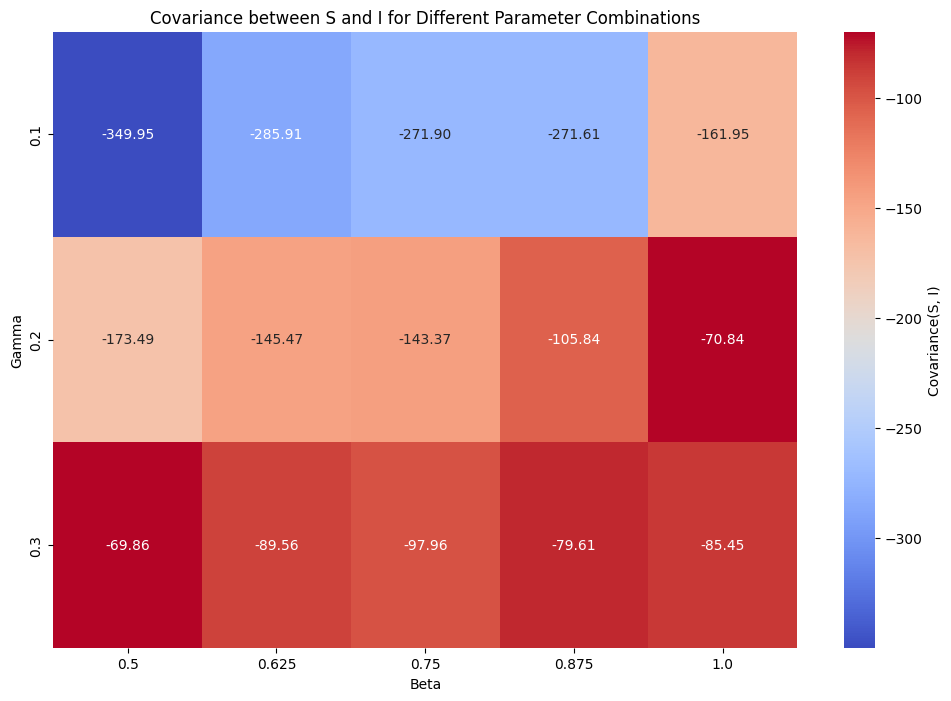

In [226]:
# Initialize lists to store results
covariances = []

# Vary parameters
for beta in np.linspace(0.5, 1, 5):
    for gamma in np.linspace(0.1, 0.3, 3):
        # Simulate the model for each combination of beta and gamma
        results = []

        for _ in range(n_runs):
            S, I, R, t = Gillespies(S_init, I_init, R_init, tend, beta, gamma)
            results.append((np.array(S), np.array(I), np.array(R), np.array(t)))

        # Interpolate results to have consistent time points
        interp_t = np.linspace(0, tend, max_length)
        interp_S = np.array([np.interp(interp_t, result[3], result[0]) for result in results])
        interp_I = np.array([np.interp(interp_t, result[3], result[1]) for result in results])

        # Calculate covariance for each combination
        cov_matrix = np.cov(interp_S.flatten(), interp_I.flatten())
        covariance_SI = cov_matrix[0, 1]

        # Store results
        covariances.append((beta, gamma, covariance_SI))


# Extract data for heatmap
beta_values = [cov[0] for cov in covariances]
gamma_values = [cov[1] for cov in covariances]
covariance_values = [cov[2] for cov in covariances]

# Create a DataFrame for heatmap
data = {'Beta': beta_values, 'Gamma': gamma_values, 'Covariance': covariance_values}
df = pd.DataFrame(data)

# Create a heatmap
plt.figure(figsize=(12, 8))
heatmap_data = df.pivot('Gamma', 'Beta', 'Covariance')
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Covariance(S, I)'})
plt.title('Covariance between S and I for Different Parameter Combinations')
plt.show()

